In [248]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import correlation
import arima
import ewma

plt.rcParams["figure.dpi"] = 200
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

SCOPE = 100

In [249]:
# Please download the dataset from https://github.com/uccmisl/5Gdataset
download = f'./5Gdataset/5G-production-dataset/Download/Driving/'
df_list = []
file_dir = download

for file in os.listdir(file_dir)[:]:
    df = pd.read_csv(file_dir+file)
    #print(df.info())
    
    df = df[['Timestamp', 'Speed', 'CellID', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI', 'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ']]
    df.replace('-', np.nan, inplace=True)
    
    df['date'] = pd.to_datetime(df['Timestamp'], format="%Y.%m.%d_%H.%M.%S")
    df.sort_values(by=['date'], inplace=True)
    df.index = df['date']

    df.drop_duplicates(subset=['date'], inplace=True)
    df.drop(columns=['Timestamp'], inplace=True)

    df['CellID'] = pd.to_numeric(df['CellID'])
    df['RSRP'] = pd.to_numeric(df['RSRP'])
    df['RSRQ'] = pd.to_numeric(df['RSRQ'])
    df['SNR'] = pd.to_numeric(df['SNR'])
    df['CQI'] = pd.to_numeric(df['CQI'])
    df['RSSI'] = pd.to_numeric(df['RSSI'])
    df['DL_bitrate'] = pd.to_numeric(df['DL_bitrate'])
    df['UL_bitrate'] = pd.to_numeric(df['UL_bitrate'])
    df['NRxRSRP'] = pd.to_numeric(df['NRxRSRP'])
    df['NRxRSRQ'] = pd.to_numeric(df['NRxRSRQ'])

    df.ffill(limit=5, inplace=True)
    df.fillna(0, inplace=True)

    df_list.append(df)

/tmp/ipykernel_970171/3538171133.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True)


In [250]:
df = pd.concat(df_list, axis=0)
df.head()
#df.to_csv('preprocessed-data/5Gdataset/Download.csv', encoding='utf-8', index=False)

Speed  CellID  RSRP  RSRQ  SNR   CQI   RSSI  DL_bitrate  \
date                                                                           
2020-02-27 17:30:15      0      13   -99 -12.0 -1.0  14.0 -105.0         214   
2020-02-27 17:30:16      2      13   -99 -13.0 -2.0  14.0 -105.0          86   
2020-02-27 17:30:17      2      13   -99 -12.0  0.0   9.0 -105.0          30   
2020-02-27 17:30:19      2      13   -99 -12.0  0.0   9.0 -105.0           0   
2020-02-27 17:30:20      2      13   -98 -11.0 -1.0  14.0 -105.0           0   

                     UL_bitrate  NRxRSRP  NRxRSRQ                date  
date                                                                   
2020-02-27 17:30:15          94   -101.0    -14.0 2020-02-27 17:30:15  
2020-02-27 17:30:16         313   -101.0    -13.0 2020-02-27 17:30:16  
2020-02-27 17:30:17          11   -102.0    -15.0 2020-02-27 17:30:17  
2020-02-27 17:30:19           0   -102.0    -15.0 2020-02-27 17:30:19  
2020-02-27 17:30:20           0   -101.0    -15.0 2020-02-27 17:30:20

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24446 entries, 2020-02-27 17:30:15 to 2019-12-16 08:05:59
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Speed       24446 non-null  int64         
 1   CellID      24446 non-null  int64         
 2   RSRP        24446 non-null  int64         
 3   RSRQ        24446 non-null  float64       
 4   SNR         24446 non-null  float64       
 5   CQI         24446 non-null  float64       
 6   RSSI        24446 non-null  float64       
 7   DL_bitrate  24446 non-null  int64         
 8   UL_bitrate  24446 non-null  int64         
 9   NRxRSRP     24446 non-null  float64       
 10  NRxRSRQ     24446 non-null  float64       
 11  date        24446 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 2.4 MB


In [252]:
# Drop NR metrics due to low correlation
df.drop(columns=['NRxRSRP', 'NRxRSRQ'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24446 entries, 2020-02-27 17:30:15 to 2019-12-16 08:05:59
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Speed       24446 non-null  int64         
 1   CellID      24446 non-null  int64         
 2   RSRP        24446 non-null  int64         
 3   RSRQ        24446 non-null  float64       
 4   SNR         24446 non-null  float64       
 5   CQI         24446 non-null  float64       
 6   RSSI        24446 non-null  float64       
 7   DL_bitrate  24446 non-null  int64         
 8   UL_bitrate  24446 non-null  int64         
 9   date        24446 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(5)
memory usage: 2.1 MB


In [253]:
directory = 'preprocessed-data/5Gdataset'
if not os.path.exists(directory):
    os.makedirs(directory)

df.to_csv('preprocessed-data/5Gdataset/download.csv', encoding='utf-8', index=False)

In [254]:
# Reset index for visualization
df_plot = df.copy()
df_plot.reset_index(drop=True, inplace=True)
#df.info()xw

In [255]:
# Calculate mean and standard deviation
mean_value = df_plot['DL_bitrate'].div(1024).mean()
std_value = df_plot['DL_bitrate'].div(1024).std()

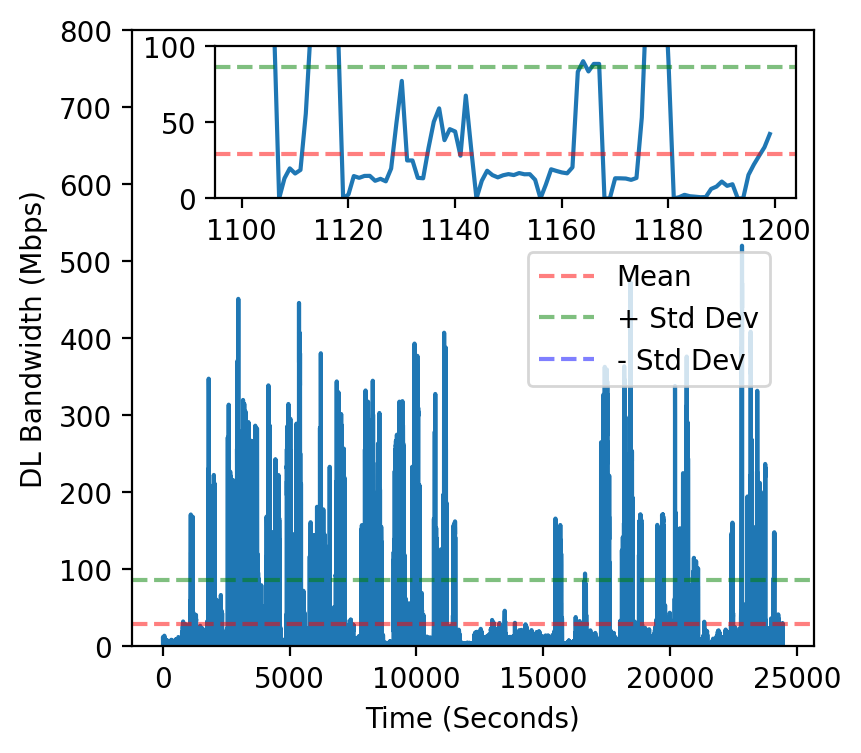

In [256]:
figure_size = (4.4, 4)
fig, ax1 = plt.subplots(figsize=figure_size, dpi=200)
ax1.set_xlabel('Time (Seconds)')
ax1.set_ylabel('DL Bandwidth (Mbps)')
ax1.set_ylim(bottom=0, top=800)

left, bottom, width, height = [0.22, 0.67, 0.66, 0.19]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_ylim(bottom=0, top=100)

ax1.plot(df_plot['DL_bitrate'].div(1024))

alpha_val = 0.5
# Plot mean and standard deviation lines on ax1
ax1.axhline(mean_value, color='r', linestyle='--', alpha=alpha_val, label='Mean')
ax1.axhline(mean_value + std_value, color='g', linestyle='--', alpha=alpha_val, label='+ Std Dev')
ax1.axhline(mean_value - std_value, color='b', linestyle='--', alpha=alpha_val, label='- Std Dev')

# Add legend
ax1.legend(loc='lower left', bbox_to_anchor=(0.56, 0.4))

ax2.plot(df_plot['DL_bitrate'].div(1024)[1100:1200])
# Plot mean and standard deviation lines on ax2
ax2.axhline(mean_value, color='r', linestyle='--', alpha=alpha_val, label='Mean')
ax2.axhline(mean_value + std_value, color='g', linestyle='--', alpha=alpha_val, label='+ Std Dev')
ax2.axhline(mean_value - std_value, color='b', linestyle='--', alpha=alpha_val, label='- Std Dev')
fig.savefig(f'plots/Beyond5G-data.pdf', bbox_inches='tight')
plt.show()

In [200]:
df['DL_bitrate'].div(1024).describe(include='all')

count    24446.000000
mean        28.947031
std         57.399362
min          0.000000
25%          3.012695
50%          8.698242
75%         20.155762
max        520.415039
Name: DL_bitrate, dtype: float64

In [201]:
df.describe(include='all')

Speed        CellID          RSRP          RSRQ           SNR  \
count  24446.000000  24446.000000  24446.000000  24446.000000  24446.000000   
mean      32.271046   5600.478442    -82.260124    -10.059192      4.339687   
min        0.000000      1.000000   -200.000000    -22.000000    -30.000000   
25%       21.000000      2.000000    -92.000000    -13.000000      0.000000   
50%       33.000000     12.000000    -83.000000    -11.000000      2.000000   
75%       43.000000     13.000000    -73.000000     -8.000000      9.000000   
max       89.000000  57666.000000    -49.000000      0.000000     35.000000   
std       15.815427  14743.332635     13.080832      5.028897      8.146770   

                CQI          RSSI     DL_bitrate    UL_bitrate  \
count  24446.000000  24446.000000   24446.000000  24446.000000   
mean       8.830238    -69.576209   29641.759347    112.115929   
min        0.000000   -113.000000       0.000000      0.000000   
25%        6.000000    -93.000000    3085.000000     51.000000   
50%       10.000000    -79.000000    8907.000000     89.000000   
75%       13.000000    -61.000000   20639.500000    156.000000   
max       15.000000      0.000000  532905.000000   1626.000000   
std        4.780883     33.690568   58776.946871     95.222776   

                                date  
count                          24446  
mean   2020-01-17 22:23:23.760124416  
min              2019-12-14 10:16:30  
25%    2019-12-16 14:48:09.249999872  
50%       2020-01-16 10:11:57.500000  
75%    2020-02-13 15:57:07.750000128  
max              2020-02-27 20:50:06  
std                              NaN

In [202]:
df.head()

Speed  CellID  RSRP  RSRQ  SNR   CQI   RSSI  DL_bitrate  \
date                                                                           
2020-02-27 17:30:15      0      13   -99 -12.0 -1.0  14.0 -105.0         214   
2020-02-27 17:30:16      2      13   -99 -13.0 -2.0  14.0 -105.0          86   
2020-02-27 17:30:17      2      13   -99 -12.0  0.0   9.0 -105.0          30   
2020-02-27 17:30:19      2      13   -99 -12.0  0.0   9.0 -105.0           0   
2020-02-27 17:30:20      2      13   -98 -11.0 -1.0  14.0 -105.0           0   

                     UL_bitrate                date  
date                                                 
2020-02-27 17:30:15          94 2020-02-27 17:30:15  
2020-02-27 17:30:16         313 2020-02-27 17:30:16  
2020-02-27 17:30:17          11 2020-02-27 17:30:17  
2020-02-27 17:30:19           0 2020-02-27 17:30:19  
2020-02-27 17:30:20           0 2020-02-27 17:30:20

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24446 entries, 2020-02-27 17:30:15 to 2019-12-16 08:05:59
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Speed       24446 non-null  int64         
 1   CellID      24446 non-null  int64         
 2   RSRP        24446 non-null  int64         
 3   RSRQ        24446 non-null  float64       
 4   SNR         24446 non-null  float64       
 5   CQI         24446 non-null  float64       
 6   RSSI        24446 non-null  float64       
 7   DL_bitrate  24446 non-null  int64         
 8   UL_bitrate  24446 non-null  int64         
 9   date        24446 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(5)
memory usage: 2.1 MB


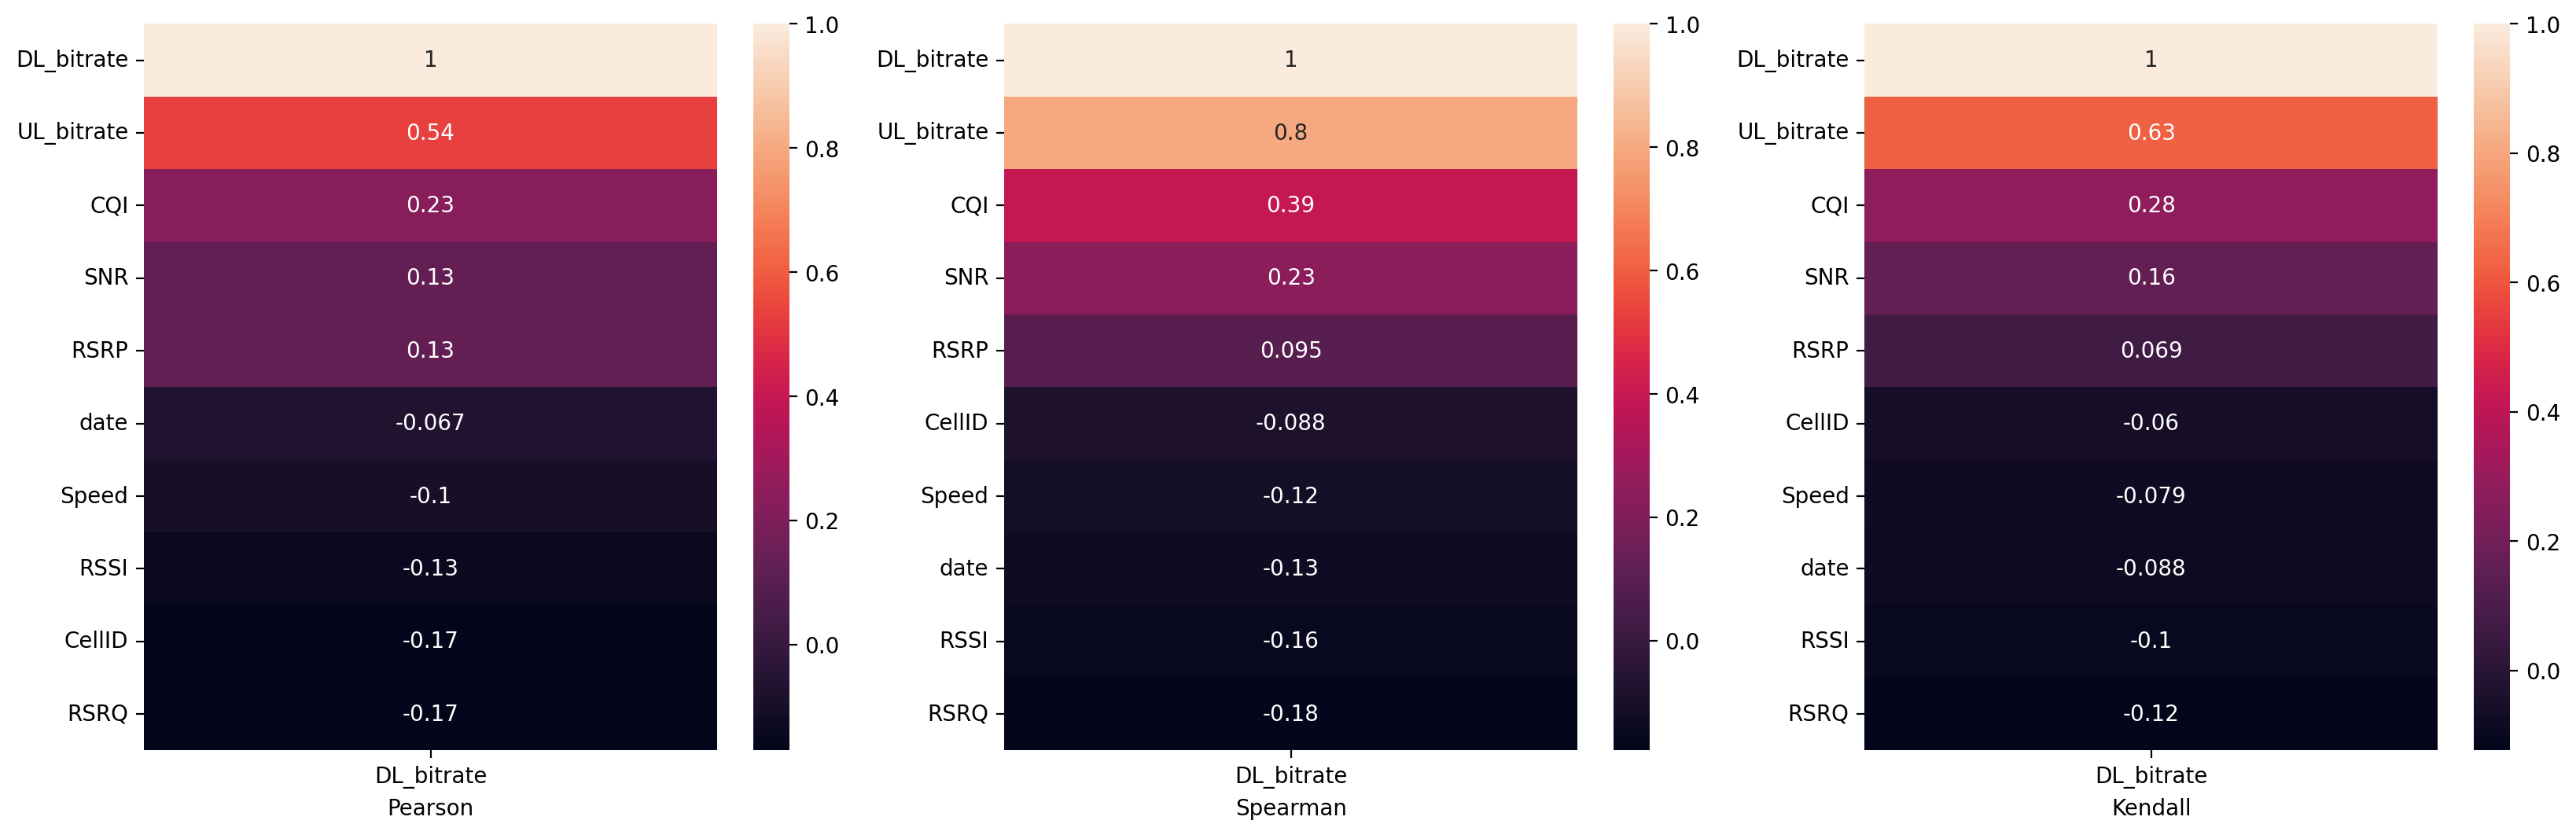

In [204]:
pearson, spearman, kendall = correlation.multi(df, 'DL_bitrate')

In [205]:
df_corr = pearson
df_corr['pearson'] = pearson
df_corr['spearman'] = spearman
df_corr['kendall'] = kendall
df_corr.drop(columns=['DL_bitrate'], inplace=True)

df_corr['average'] = df_corr.mean(axis=1)
df_corr

pearson  spearman   kendall   average
DL_bitrate  1.000000  1.000000  1.000000  1.000000
UL_bitrate  0.536888  0.798079  0.626604  0.653857
CQI         0.228782  0.394887  0.280505  0.301391
SNR         0.129457  0.233518  0.161655  0.174877
RSRP        0.127124  0.094679  0.068900  0.096901
date       -0.067468 -0.129775 -0.087590 -0.094944
Speed      -0.101103 -0.116020 -0.079080 -0.098734
RSSI       -0.134952 -0.155026 -0.101077 -0.130352
CellID     -0.168014 -0.087570 -0.059953 -0.105179
RSRQ       -0.170550 -0.178101 -0.123841 -0.157497

In [206]:
# EWMA

# scope is duration of test dataset (%20 of whole data)
scope = int(len(df) * 0.2) #4889
tail = df.tail(scope)
tail = tail[['DL_bitrate']]

span = 8
pred_len = 1

ewma.predict_and_evaluate(tail, 'DL_bitrate', span, pred_len)

EWMA8 rmse: 34059.84583028962, mae: 14355.28310548527
Shifted rmse: 25726.171300609807, mae: 8917.333401639344


In [207]:
# ARIMA

# lenght of last %20 + window size
scope = 4889 + 32
df_arima = df.tail(scope)
#df_arima = df_arima[['DL_bitrate']]
df_arima.head()

Speed  CellID  RSRP  RSRQ  SNR   CQI   RSSI  DL_bitrate  \
date                                                                           
2020-02-14 07:31:23     45       2   -93  -8.0  5.0   6.0  -99.0           1   
2020-02-14 07:31:24     45       2   -93  -8.0  5.0   6.0  -99.0           1   
2020-02-14 07:31:25     45       2   -95 -12.0  0.0  10.0 -101.0        7888   
2020-02-14 07:31:26     51       2   -95 -12.0  0.0  10.0  -95.0       19149   
2020-02-14 07:31:27     51       2   -95  -9.0  6.0  11.0  -93.0       23781   

                     UL_bitrate                date  
date                                                 
2020-02-14 07:31:23           1 2020-02-14 07:31:23  
2020-02-14 07:31:24           1 2020-02-14 07:31:24  
2020-02-14 07:31:25         152 2020-02-14 07:31:25  
2020-02-14 07:31:26         136 2020-02-14 07:31:26  
2020-02-14 07:31:27         143 2020-02-14 07:31:27

In [208]:
# Define the rolling window size and prediction horizon
window_size = 32
prediction_horizon = 1

# Predict the next value using ARIMA model with a rolling window
predictions = arima.predict_next_value(df_arima['DL_bitrate'], window_size=window_size, horizon=prediction_horizon)

arima.evaluate(predictions, df_arima, window_size, prediction_horizon)

/data22/bde/.pyenv/versions/3.11.7/envs/bandseer/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/data22/bde/.pyenv/versions/3.11.7/envs/bandseer/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/data22/bde/.pyenv/versions/3.11.7/envs/bandseer/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/data22/bde/.pyenv/versions/3.11.7/envs/bandseer/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

len(predictions): 4889
len(predictions[0]): 1


KeyError: 'bandwidth'